In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
import sys
sys.path.append('../src')

import typing as tp
from pathlib import Path, PosixPath

import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import correlate as imfilter

from imutils import imread, imshow, imsshow, rgb2gray, gray2gray3d, make_noised, crop2even, center_crop
from data.convolution import convolve
from deconv.classic.fista.fista import fista, norm_fro, prox_l1
from deconv.classic.fista.perform_wavelet_transf import perform_wavelet_transf

from metrics import psnr, ssim, mse, rmse

plt.gray()

<Figure size 640x480 with 0 Axes>

In [5]:
image = imread('../datasets/gt/BSDS300/2092.jpg')
image = crop2even(image)
image = rgb2gray(image)
image_3d = gray2gray3d(image)

psf_gauss_ = np.load('../datasets/kernels/gauss-blur/processed/synthetic/synthetic-0.npy', allow_pickle=True).item()['psf']
psf_motion = np.load('../datasets/kernels/motion-blur/processed/synthetic/synthetic-0.npy', allow_pickle=True).item()['psf']
psf_eye = np.load('../datasets/kernels/eye-psf/processed/synthetic/big-psf-0.npy', allow_pickle=True).item()['psf']

mu = 0
sigma = 0.01


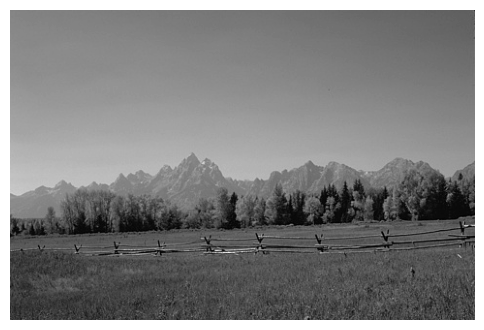

In [6]:
imshow(image, figsize=(6, 6))

### Source code

In [7]:
import sys
sys.path.append('../src')

from typing import Callable

import numpy as np
from math import ceil
from scipy.ndimage import correlate as imfilter

from deconv.classic.fista.perform_wavelet_transf import perform_wavelet_transf


def norm_fro(img: np.ndarray) -> float:
    return np.sqrt(np.sum(img * img))


def prox_l1(x: np.ndarray, alpha: float) -> np.ndarray:
    if alpha < 0:
        ValueError('usage: prox_l1(x,alpha) - alpha should be positive')
    return np.maximum(np.abs(x) - alpha, 0) * np.sign(x)


def psf_gauss(dim: tuple[float, float], s: float) -> np.ndarray:
    n, m = dim
    x = range(-int(n/2), ceil(n/2))
    y = range(-int(m/2), ceil(m/2))
    X, Y = np.meshgrid(x, y)
    PSF = np.exp(
        -(X**2) / (2 * s ** 2) -
         (Y**2) / (2 * s ** 2)
    )
    PSF = PSF / np.sum(PSF)
    return PSF


def fista(
    Ffun: Callable[[np.ndarray], float],
    Ffun_grad: Callable[[np.ndarray, np.ndarray], float],
    Gfun: Callable[[np.ndarray], float],
    Gfun_prox: Callable[[np.ndarray, float], np.ndarray],
    lambda_: float,
    startx: np.ndarray,
    max_iter: int,
    Lstart: int=1,
    eps: float=1e-5,
    eco_flag: bool=False,
    const_flag: bool=False,
    regret_flag: bool=False,
    eta: float=2.0,
    monotone_flag: bool=False,
):
    startx = Gfun_prox(startx, 1e-4)

    if not eco_flag:
        prevFvalue = Ffun(startx)
        prevGvalue = Gfun(startx)
        best_vector = startx
        best_value = prevFvalue + lambda_ * prevGvalue  # best value for objective function found so far

    if const_flag:
        L = Lstart
    else:
        if regret_flag:
            L = Lstart * eta  # in the first iteration it will be divided by eta
        else:
            L = Lstart

    Feps = 1e-10  # Inner epsilon for comparing newFvalue and quad_aprrox
    done = False
    iternu = 0  # iteration number
    prevx = startx
    newy = startx
    prevt: float = 1.0
    newx = prevx
    parout = {}

    if eco_flag:
        const_flag = True

    while iternu < max_iter and not done:
        iternu = iternu + 1

        if not const_flag and regret_flag:
            L = L / eta

        grad = Ffun_grad(newy)
        prox_val = Gfun_prox(newy - 1 / L * grad, lambda_ / L)
        if not eco_flag:
            newFvalue = Ffun(prox_val)

        if not const_flag:
            # search for appropriate L
            FvalY = Ffun(newy)
            quad_approx = FvalY + np.trace(grad.T @ (prox_val - newy)) + L / 2 * norm_fro(prox_val - newy)**2
            while newFvalue  > quad_approx + Feps:
                L = L * eta
                prox_val = Gfun_prox(newy - 1 / L * grad, lambda_ / L)
                newFvalue = Ffun(prox_val)
                quad_approx = FvalY + np.trace(grad.T @ (prox_val - newy)) + L / 2 * norm_fro(prox_val - newy)**2

        newt = 0.5 * (1.0 + np.sqrt(1 + 4 * prevt ** 2))
        if not eco_flag:
            newGvalue = Gfun(prox_val)

        if monotone_flag:
            newz = prox_val
            if newFvalue + lambda_ * newGvalue < prevFvalue + lambda_ * prevGvalue:
                newx = prox_val # %newz
            else:
                newFvalue = prevFvalue
                newGvalue = prevGvalue

            newy = newx + prevt / newt * (newz - newx) + (prevt - 1) / newt * (newx - prevx)
            prevx = newx
            prevFvalue = newFvalue
            prevGvalue = newGvalue
        else:
            newx = prox_val
            if norm_fro(newx - prevx) < eps:
                done = True

            newy = newx + (prevt - 1) / newt * (newx - prevx)
            prevx = newx

        prevt = newt
        if not eco_flag:
            newFGvalue = newFvalue + lambda_ * newGvalue
            if True:  # nargout == 3:
                # updating parout
                parout.setdefault('funValVec', []).append(newFGvalue)
                if not const_flag:
                    parout.setdefault('LValVec', []).append(L)

            if monotone_flag or (newFGvalue < best_value):
                best_vector = newx
                best_value = newFGvalue
                
    if eco_flag:
        out = newx
    else:
        out = best_vector

    if not eco_flag:
        fmin = best_value
    else:
        fmin = Ffun(out) + lambda_ * Gfun(out)

    parout['iterNum'] = iternu
    return out, fmin, parout


### Example 1

In [8]:
import matplotlib.pyplot as plt
with open('/home/chaganovaob/edu/non-blind-deconvolution-benchmark/datasets/gt/BSDS300/2092.jpg', 'rb') as pgmf:
    X = plt.imread(pgmf)
X = X / 255
X = X[:, :, 0]
X = center_crop(X, 256, 256)

P = psf_gauss((9, 9), 4)
Bobs = imfilter(X, P, mode='mirror') + 1e-3 * np.random.rand(*X.shape)

def fpic(x):
    return norm_fro(imfilter(x, P, mode='mirror') - Bobs)**2

def grad_fpic(x):
    return 2 * imfilter(imfilter(x, P, mode='mirror') - Bobs, P, mode='mirror')

options = {'ti': 0}
Jmin = 4

w = lambda f: perform_wavelet_transf(f, Jmin, +1, **options)
wi = lambda f: perform_wavelet_transf(f, Jmin, -1, **options)
Gpic = lambda x: np.sum(np.abs(w(x)))
prox_gpic = lambda x, a: wi(prox_l1(w(x),a))

x_fista = fista(
    Ffun=fpic,
    Ffun_grad=grad_fpic,
    Gfun=Gpic,
    Gfun_prox=prox_gpic,
    lambda_=1e-10,
    startx=np.zeros_like(Bobs, dtype=np.float64),
    max_iter=100,  
    eco_flag=False,
)

SSIM: 0.94 vs 0.83
PSNR: 32.05 vs 26.36
MSE:  0.00062 vs 0.00231


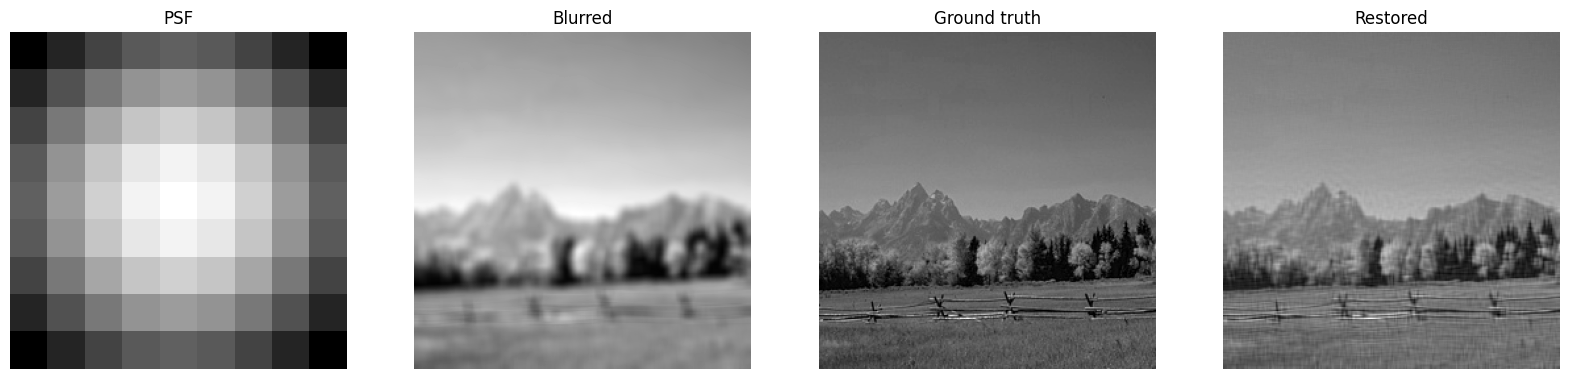

In [9]:
imsshow([P, Bobs, X, x_fista[0]], titles=['PSF', 'Blurred', 'Ground truth', 'Restored'], figsize=(20, 7))

print(f'SSIM: {ssim(X, x_fista[0]):.2f} vs {ssim(X, Bobs):.2f}')
print(f'PSNR: {psnr(X, x_fista[0]):.2f} vs {psnr(X, Bobs):.2f}')
print(f'MSE:  {mse(X, x_fista[0]):.5f} vs {mse(X, Bobs):.5f}')

### Example 2

In [14]:
import matplotlib.pyplot as plt
with open('/home/chaganovaob/edu/non-blind-deconvolution-benchmark/datasets/gt/BSDS300/2092.jpg', 'rb') as pgmf:
    X = plt.imread(pgmf)
X = X / 255
X = X[:, :, 0]
X = center_crop(X, 256, 256)

P = psf_gauss_
Bobs = imfilter(X, P, mode='mirror') + 1e-3 * np.random.rand(*X.shape)

def fpic(x):
    return norm_fro(imfilter(x, P, mode='mirror') - Bobs)**2

def grad_fpic(x):
    return 2 * imfilter(imfilter(x, P, mode='mirror') - Bobs, P, mode='mirror')

options = {'ti': 0}
Jmin = 4

w = lambda f: perform_wavelet_transf(f, Jmin, +1, **options)
wi = lambda f: perform_wavelet_transf(f, Jmin, -1, **options)
Gpic = lambda x: np.sum(np.abs(w(x)))
prox_gpic = lambda x, a: wi(prox_l1(w(x),a))

x_fista = fista(
    Ffun=fpic,
    Ffun_grad=grad_fpic,
    Gfun=Gpic,
    Gfun_prox=prox_gpic,
    lambda_=1e-6, 
    startx=np.zeros_like(Bobs, dtype=np.float64),
    max_iter=100,  
    eco_flag=False,
)

SSIM: 0.85 vs 0.81
PSNR: 26.93 vs 25.59
MSE:  0.00203 vs 0.00276


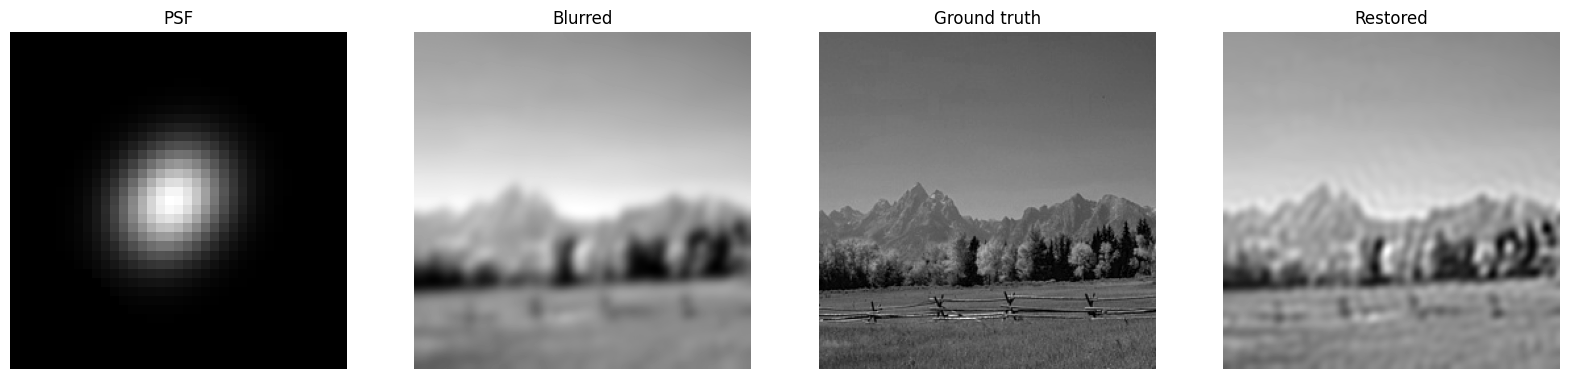

In [15]:
imsshow([P, Bobs, X, x_fista[0]], titles=['PSF', 'Blurred', 'Ground truth', 'Restored'], figsize=(20, 7))

print(f'SSIM: {ssim(X, x_fista[0]):.2f} vs {ssim(X, Bobs):.2f}')
print(f'PSNR: {psnr(X, x_fista[0]):.2f} vs {psnr(X, Bobs):.2f}')
print(f'MSE:  {mse(X, x_fista[0]):.5f} vs {mse(X, Bobs):.5f}')

### Example 3

In [22]:
import matplotlib.pyplot as plt
with open('/home/chaganovaob/edu/non-blind-deconvolution-benchmark/datasets/gt/BSDS300/2092.jpg', 'rb') as pgmf:
    X = plt.imread(pgmf)
X = X / 255
X = X[:, :, 0]
X = center_crop(X, 256, 256)

P = psf_motion
Bobs = imfilter(X, P, mode='mirror') + 1e-3 * np.random.rand(*X.shape)

def fpic(x):
    return norm_fro(imfilter(x, P, mode='mirror') - Bobs)**2

def grad_fpic(x):
    return 2 * imfilter(imfilter(x, P, mode='mirror') - Bobs, P, mode='mirror')

options = {'ti': 0}
Jmin = 4

w = lambda f: perform_wavelet_transf(f, Jmin, +1, **options)
wi = lambda f: perform_wavelet_transf(f, Jmin, -1, **options)
Gpic = lambda x: np.sum(np.abs(w(x)))
prox_gpic = lambda x, a: wi(prox_l1(w(x),a))

x_fista = fista(
    Ffun=fpic,
    Ffun_grad=grad_fpic,
    Gfun=Gpic,
    Gfun_prox=prox_gpic,
    lambda_=1e-10, 
    startx=np.zeros_like(Bobs, dtype=np.float64),
    max_iter=100,  
    eco_flag=False,
)

SSIM: 0.76 vs 0.77
PSNR: 23.99 vs 24.44
MSE:  0.00399 vs 0.00359


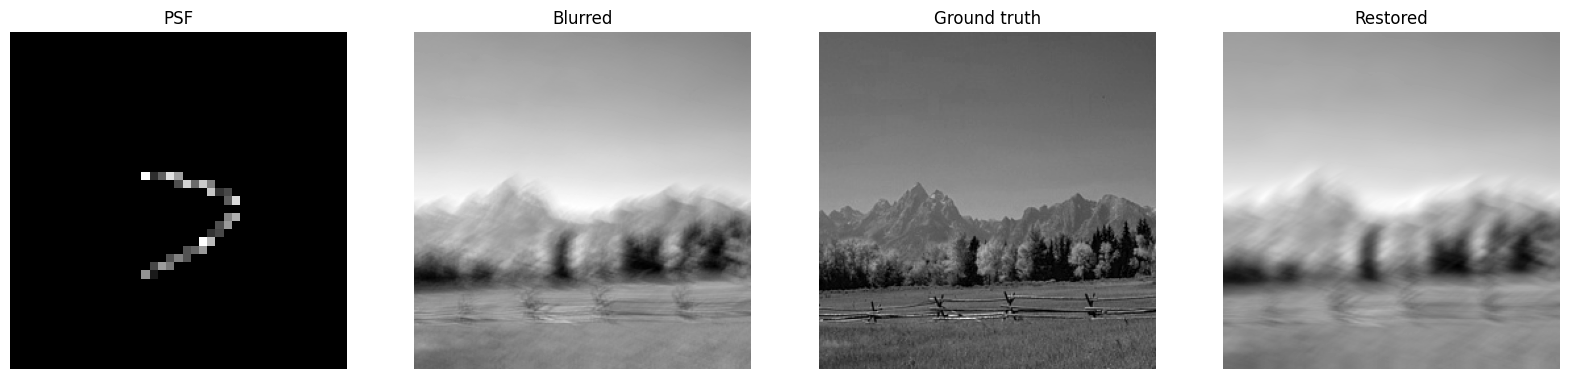

In [23]:
imsshow([P, Bobs, X, x_fista[0]], titles=['PSF', 'Blurred', 'Ground truth', 'Restored'], figsize=(20, 7))

print(f'SSIM: {ssim(X, x_fista[0]):.2f} vs {ssim(X, Bobs):.2f}')
print(f'PSNR: {psnr(X, x_fista[0]):.2f} vs {psnr(X, Bobs):.2f}')
print(f'MSE:  {mse(X, x_fista[0]):.5f} vs {mse(X, Bobs):.5f}')

### Example 4

In [7]:
import matplotlib.pyplot as plt
with open('/home/chaganovaob/edu/non-blind-deconvolution-benchmark/datasets/gt/BSDS300/2092.jpg', 'rb') as pgmf:
    X = plt.imread(pgmf)
X = X / 255
X = X[:, :, 0]
X = center_crop(X, 256, 256)

P = psf_eye
Bobs = imfilter(X, P, mode='mirror') + 1e-3 * np.random.rand(*X.shape)

def fpic(x):
    return norm_fro(imfilter(x, P, mode='mirror') - Bobs)**2

def grad_fpic(x):
    return 2 * imfilter(imfilter(x, P, mode='mirror') - Bobs, P, mode='mirror')

options = {'ti': 0}
Jmin = 4

w = lambda f: perform_wavelet_transf(f, Jmin, +1, **options)
wi = lambda f: perform_wavelet_transf(f, Jmin, -1, **options)
Gpic = lambda x: np.sum(np.abs(w(x)))
prox_gpic = lambda x, a: wi(prox_l1(w(x),a))

x_fista = fista(
    Ffun=fpic,
    Ffun_grad=grad_fpic,
    Gfun=Gpic,
    Gfun_prox=prox_gpic,
    lambda_=1e-10, 
    startx=np.zeros_like(Bobs, dtype=np.float64),
    max_iter=100,  
    eco_flag=False,
)

: 

: 

In [ ]:
imsshow([P, Bobs, X, x_fista[0]], titles=['PSF', 'Blurred', 'Ground truth', 'Restored'], figsize=(20, 7))

print(f'SSIM: {ssim(X, x_fista[0]):.2f} vs {ssim(X, Bobs):.2f}')
print(f'PSNR: {psnr(X, x_fista[0]):.2f} vs {psnr(X, Bobs):.2f}')
print(f'MSE:  {mse(X, x_fista[0]):.5f} vs {mse(X, Bobs):.5f}')